# Dependencies and files

## Imports

In [1]:
import warnings
import scanpy as sc
import anndata as an
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

import seaborn as sns
import os

import time
from tqdm.notebook import tqdm
import requests
import utils.cluster_visualisation as vis

from scipy.cluster.hierarchy import average, leaves_list
from scipy.spatial.distance import pdist, squareform

sc.settings.set_figure_params(dpi=80)
#sc.set_figure_params(facecolor="white", figsize=(8, 8))
warnings.simplefilter(action='ignore', category=FutureWarning)
sc.settings.verbosity = 3

# Global variables

In [2]:
figures_dir = f'human_specific_genes/figures/'
os.makedirs(figures_dir, exist_ok=True)

In [3]:
layers = ['L1', 'L2', 'L3', 'L4', 'L5', "L6", 'WM']

## Load files

In [4]:
pb_dir_path = 'data/pseudobulks/'

In [5]:
os.listdir(pb_dir_path)

['pb_age.h5ad',
 'pb_chimp.h5ad',
 'pb_human.h5ad',
 'pb_macaque.h5ad',
 'pb_mammals.h5ad',
 'pb_spatial_libd_human.h5ad',
 'pseudobulk_all_four.h5ad',
 'pseudobulk_all_mammals.h5ad',
 'pseudobulk_humans.h5ad']

### Pseudobulks

In [6]:
adata_pb = sc.read_h5ad(pb_dir_path + 'pseudobulk_all_four.h5ad')
adata_pb.obs_names = list(map(lambda x: "spatial_libd_human_" + x if "151" in x else x, adata_pb.obs_names.tolist()))
adata_pb

AnnData object with n_obs × n_vars = 165 × 15367
    obs: 'layer', 'sample_id', 'psbulk_cells', 'psbulk_counts', 'condition', 'lib_size', 'log_lib_size'
    var: 'feature_types', 'mt', 'hb', 'ribo'
    uns: 'X_pca_mean_norm', 'condition_colors', 'layer_colors', 'log1p', 'pca'
    obsm: 'X_pca', 'X_pca_mean_norm'
    varm: 'PCs', 'X_pca_mean_norm'
    layers: 'counts', 'mean_norm', 'psbulk_props'

Let's save gene profiles to dataframe

In [7]:
df = pd.DataFrame(adata_pb.layers["mean_norm"], index=adata_pb.obs_names, columns=adata_pb.var_names)

Sort pseudobulk samples by specie and layer

In [8]:
sample_order = dict()
for cond in ['human', 'chimp', 'macaque', 'spatial_libd_human']:
    samples = df.loc[df.index.str.contains(cond)].index
    order = sorted(samples.tolist(), key=lambda x: x[-2:])
    order_laminar = list(filter(lambda x: 'L' in x, order))
    order_wm = list(filter(lambda x: 'WM' in x, order))
    sample_order[cond] = order_wm + order_laminar
sample_order['all'] = sample_order['human'] + sample_order['chimp'] + sample_order['macaque'] + sample_order['spatial_libd_human']
df = df.loc[sample_order['all']]

### Differential expression results

In [9]:
from statsmodels.stats.multitest import multipletests
import pandas as pd
res_dict = dict()
res_dict['human-chimp'] = pd.read_csv('data/human_specific_genes/edgeR_human_chimp.csv', index_col=0)
res_dict['human-macaque'] = pd.read_csv('data/human_specific_genes/edgeR_human_macaque.csv', index_col=0)
res_dict['chimp-macaque'] = pd.read_csv('data/human_specific_genes/edgeR_chimp_macaque.csv', index_col=0)

for key, res_df in res_dict.items():
    mult_test = multipletests(res_df['PValue'], method='fdr_bh')
    res_df['p_val_adj'] = mult_test[1]

res_dict['human-chimp'].head()

,logFC.spline_1.human,logFC.spline_2.human,logFC.spline_3.human,logCPM,F,PValue,p_val_adj
DUSP18,0.016419,-0.408164,-0.076850,8.732532,0.599835,0.621445,1.000000
NUP133,-0.120152,-0.177927,0.152832,8.887767,0.802623,0.496042,0.956481
FRY,0.042341,0.430236,0.144912,9.310594,0.730499,0.536246,0.969740
SNAP29,-0.267528,-0.543385,0.226842,8.831206,2.844384,0.044300,0.334603
ECI2,-0.506797,-0.154881,0.250713,8.786108,2.113979,0.111451,0.532374


# Define Human Specific Genes

In [10]:
sign_genes = lambda df, pval: df[df.p_val_adj < pval].index
sign_genes_dict = {key:sign_genes(df, 0.05) for key, df in res_dict.items()}
sign_genes_dict['chimp-macaque'] = sign_genes(res_dict['chimp-macaque'], 0.2)
sign_genes_dict

{'human-chimp': Index(['EPHA7', 'CAPRIN1', 'ERC1', 'APBA1', 'TMCC2', 'LDHB', 'ANK3', 'ROBO2',
        'CRIM1', 'SPOCK1',
        ...
        'CAMLG', 'MRPL51', 'AMZ2', 'HPCAL4', 'ALCAM', 'SNAP25', 'RAP2A',
        'PHYHIP', 'TMEM59L', 'ELAVL4'],
       dtype='object', length=261),
 'human-macaque': Index(['LRRC4', 'DNAJC19', 'PAPSS2', 'PACS2', 'ZNF277', 'PARK7', 'GATAD1',
        'EFHD2', 'IDH2', 'ZDHHC9',
        ...
        'CSDE1', 'ANKFY1', 'ATP6V1B2', 'SPATS2L', 'AKR1B1', 'HMGA1', 'KLHL4',
        'EMC10', 'SLC37A1', 'ELAVL4'],
       dtype='object', length=1852),
 'chimp-macaque': Index(['DNAJC19', 'EFHD2', 'IDH2', 'ZDHHC9', 'SLC23A2', 'COPRS', 'FAAP100',
        'MEST', 'CFL2', 'GALC',
        ...
        'SLA', 'ZNF536', 'SPATS2L', 'CHD4', 'AKR1B1', 'HMGA1', 'LEMD3', 'P4HB',
        'ELAVL4', 'HMGCR'],
       dtype='object', length=1588)}

Let's define Human-specific genes as $(HC\bigcap HM)\setminus CM$

In [11]:
hs_genes = sign_genes_dict['human-chimp'].intersection(sign_genes_dict['human-macaque']).difference(sign_genes_dict['chimp-macaque'])
hs_genes, hs_genes.size

(Index(['ALCAM', 'AMZ2', 'ASAH1', 'ATP1A3', 'ATP5MG', 'ATP6V1G1', 'BOLA3',
        'BRK1', 'CCSER2', 'CD47', 'CHST10', 'CKB', 'CLSTN1', 'CX3CL1', 'DCXR',
        'DLGAP4', 'ECSIT', 'EIF1B', 'EIF4G3', 'EPHB6', 'ERC1', 'ETFB', 'FBXO9',
        'GDE1', 'GNAZ', 'GSTO1', 'HSPE1', 'ID2', 'IGFBP2', 'IGFBP6', 'IGSF21',
        'KLHL2', 'LCMT1', 'LHX2', 'MACF1', 'MAP1LC3B', 'MAZ', 'MRPL51',
        'NDUFB10', 'NHP2', 'NPM1', 'NRXN1', 'NRXN2', 'NUAK1', 'OLA1', 'PCP4',
        'PDE1A', 'PES1', 'PSMB7', 'PTPRK', 'RALYL', 'RBIS', 'RGS2', 'RIMS4',
        'SCD5', 'SCN3B', 'SEPTIN6', 'SNRPD2', 'SULF2', 'SYNGAP1', 'TCEAL4',
        'TMED3', 'TRIR', 'UBA1', 'UBE2V1', 'VAT1L', 'YWHAE', 'ZBTB18',
        'ZBTB46'],
       dtype='object'),
 69)

In [12]:
background_genes = res_dict['human-chimp'].index.tolist()
len(background_genes)

7801

In [13]:
with open('data/human_specific_genes/background_genes.txt', 'w', newline='') as f:
    writer = f.write(','.join(background_genes))

In [14]:
with open('data/human_specific_genes/human_specific_genes.txt', 'w', newline='') as f:
    writer = f.write(','.join(hs_genes.tolist()))

# Validation of Human Specific Genes

Subset human specific genes and add layer and condition information

In [15]:
hs_genes = df.columns.intersection(hs_genes)
df_annotation = df[hs_genes].copy()
df_annotation['layer'] = adata_pb.obs.layer
df_annotation['condition'] = adata_pb.obs.condition

Calculate average profiles for each gene

In [16]:
layer_mean = df_annotation.groupby(['condition', 'layer']).mean()

In [17]:
from scipy.stats import spearmanr, pearsonr, kendalltau

columns = ['pear_ha', 'pear_mca', 'kend_ha', 'kend_mca', 'spearman_ha', 'spearman_mca']
corr_list = []
for gene in df_annotation.columns[:-2]:
    human_spl = layer_mean.loc['human', gene].values
    adult_spl = layer_mean.loc['spatial_libd_human', gene].values
    chimp_spl = layer_mean.loc['chimp', gene].values
    macaque_spl = layer_mean.loc['macaque', gene].values
    ch_m_spl = (chimp_spl + macaque_spl) / 2



    pear_ha = pearsonr(adult_spl, human_spl)
    pear_mca = pearsonr(adult_spl, ch_m_spl)
    kend_ha = kendalltau(adult_spl, human_spl)
    kend_mca = kendalltau(adult_spl, macaque_spl)
    sp_ha = spearmanr(adult_spl, human_spl)
    sp_mca = spearmanr(adult_spl, macaque_spl)
    corr_list.append([pear_ha[0], pear_mca[0], kend_ha[0], kend_mca[0], sp_ha[0], sp_mca[0]])

corr_df = pd.DataFrame(corr_list, columns=columns, index=df_annotation.columns[:-2])
corr_df.head()

,pear_ha,pear_mca,kend_ha,kend_mca,spearman_ha,spearman_mca
ERC1,-0.800631,-0.103297,-0.904762,-0.428571,-0.964286,-0.464286
CHST10,0.156264,0.035620,0.238095,0.238095,0.392857,0.250000
ATP6V1G1,0.103215,0.598673,-0.047619,0.809524,0.000000,0.928571
GDE1,0.336168,0.336171,0.238095,0.047619,0.357143,0.107143
ZBTB18,0.531144,0.951612,0.333333,0.809524,0.500000,0.928571


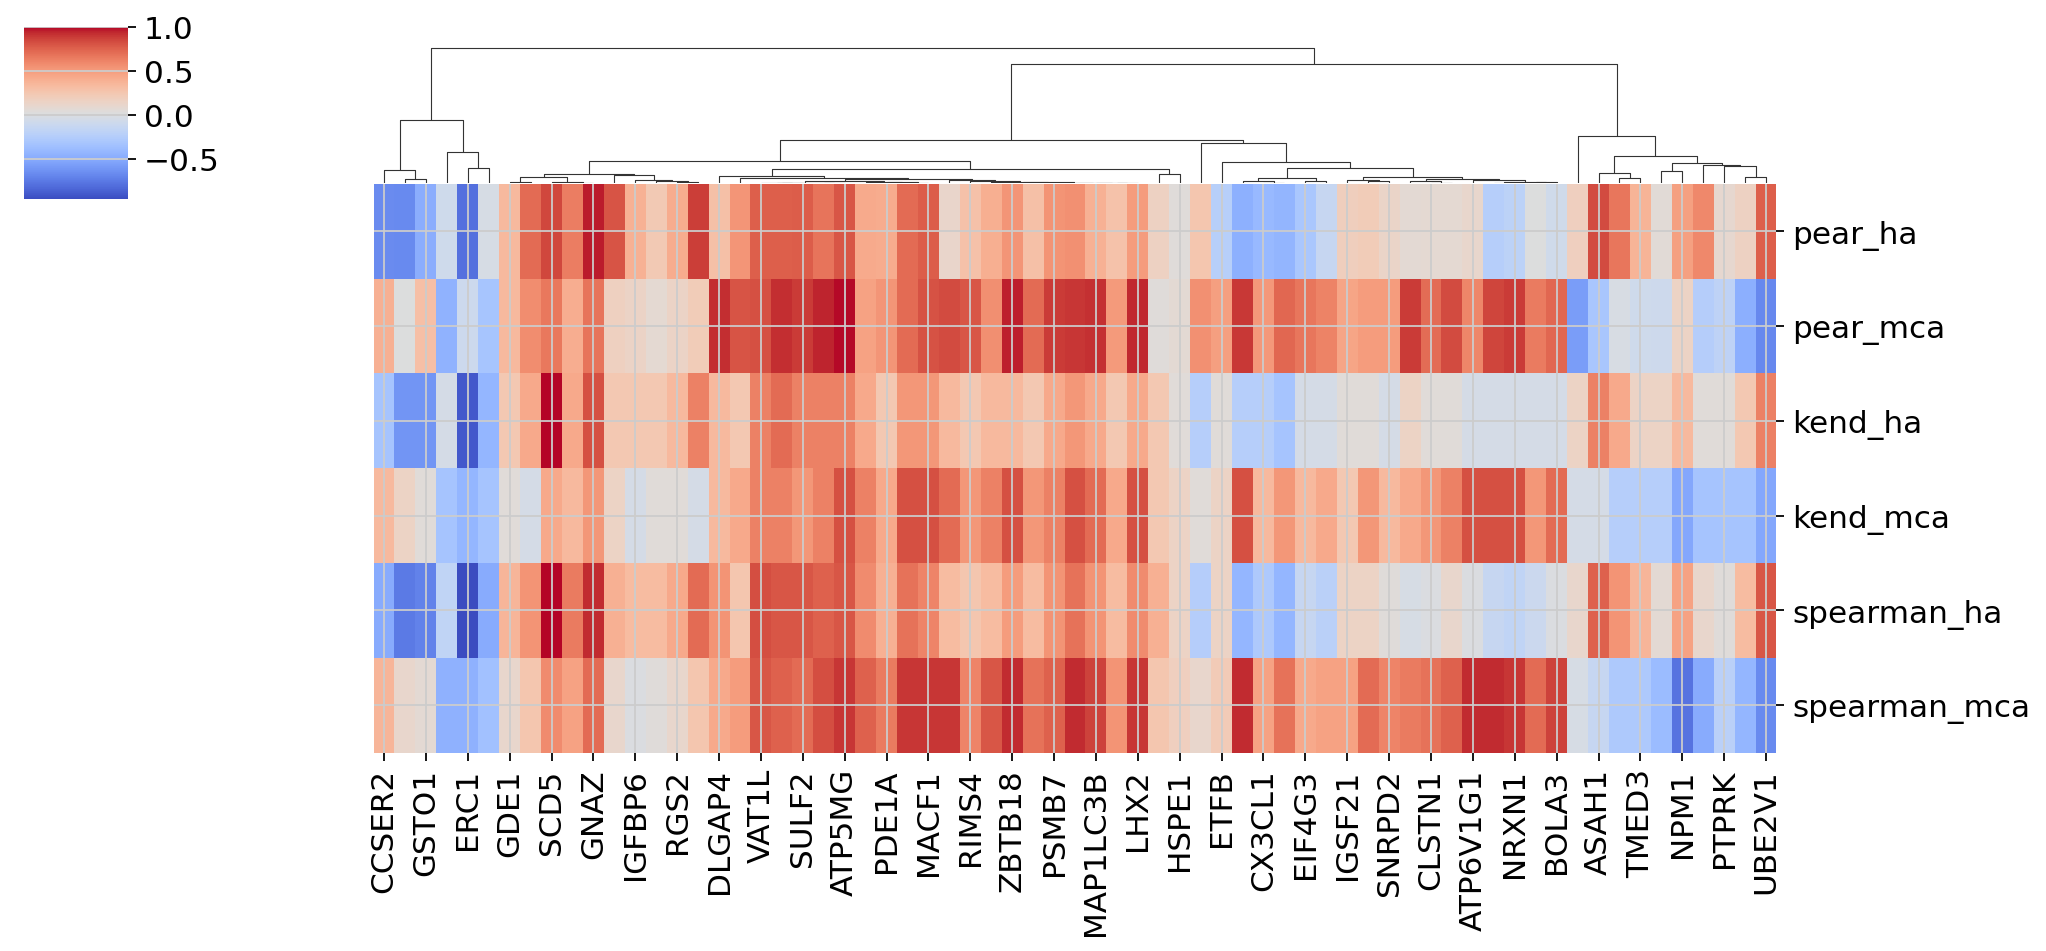

In [18]:
#fig = plt.figure(figsize=(10, 3), dpi=60)
clust = sns.clustermap(corr_df.T, cmap='coolwarm', figsize=(13, 6), row_cluster=False, metric='cosine')

In [19]:
corr_df['mean_ha'] = (corr_df['kend_ha'] + corr_df['pear_ha']) / 2
corr_df['mean_mca'] = (corr_df['kend_mca'] + corr_df['pear_mca']) / 2
corr_df['corr_diff'] = corr_df['mean_ha'] - corr_df['mean_mca']
corr_df['pear_diff'] = corr_df['pear_ha'] - corr_df['pear_mca']
corr_df['spear_diff'] = corr_df['spearman_ha'] - corr_df['spearman_mca']
corr_df['kend_diff'] = corr_df['kend_ha'] - corr_df['kend_mca']

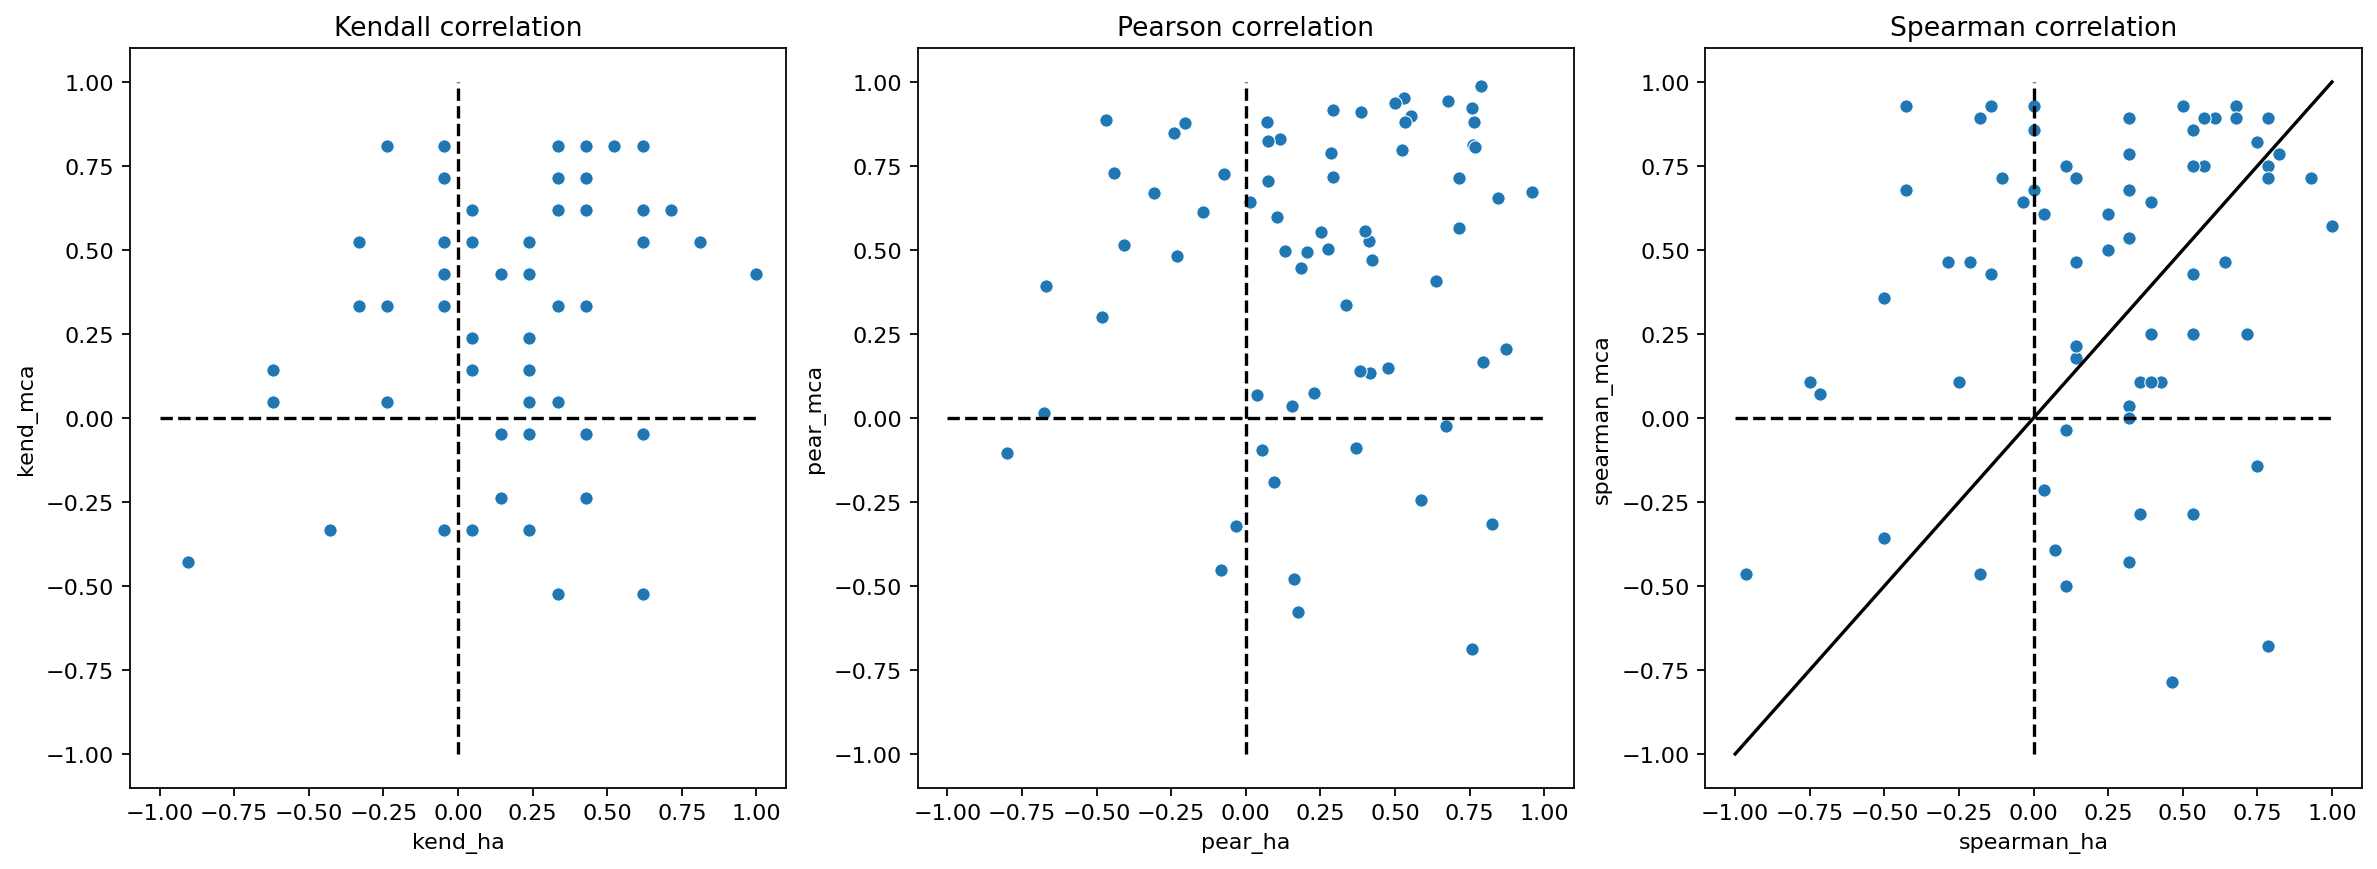

In [20]:
mpl.rcdefaults()

fig, ax = plt.subplots(1, 3, figsize=(18, 6), dpi=80)
sns.scatterplot(corr_df, x='kend_ha', y='kend_mca', ax=ax[0])
ax[0].hlines(y=0, xmin=-1, xmax=1, colors='black', linestyles='dashed')
ax[0].vlines(x=0, ymin=-1, ymax=1, colors='black', linestyles='dashed')
ax[0].set_title('Kendall correlation')
ax[0].grid(False)

sns.scatterplot(corr_df, x='pear_ha', y='pear_mca', ax=ax[1])
ax[1].hlines(y=0, xmin=-1, xmax=1, colors='black', linestyles='dashed')
ax[1].vlines(x=0, ymin=-1, ymax=1, colors='black', linestyles='dashed')
ax[1].set_title('Pearson correlation')
ax[1].grid(False)

sns.scatterplot(corr_df, x='spearman_ha', y='spearman_mca', ax=ax[2])
ax[2].hlines(y=0, xmin=-1, xmax=1, colors='black', linestyles='dashed')
ax[2].vlines(x=0, ymin=-1, ymax=1, colors='black', linestyles='dashed')
ax[2].plot([-1, 1], [-1, 1], '-', color='black')
ax[2].set_title('Spearman correlation')
ax[2].grid(False)

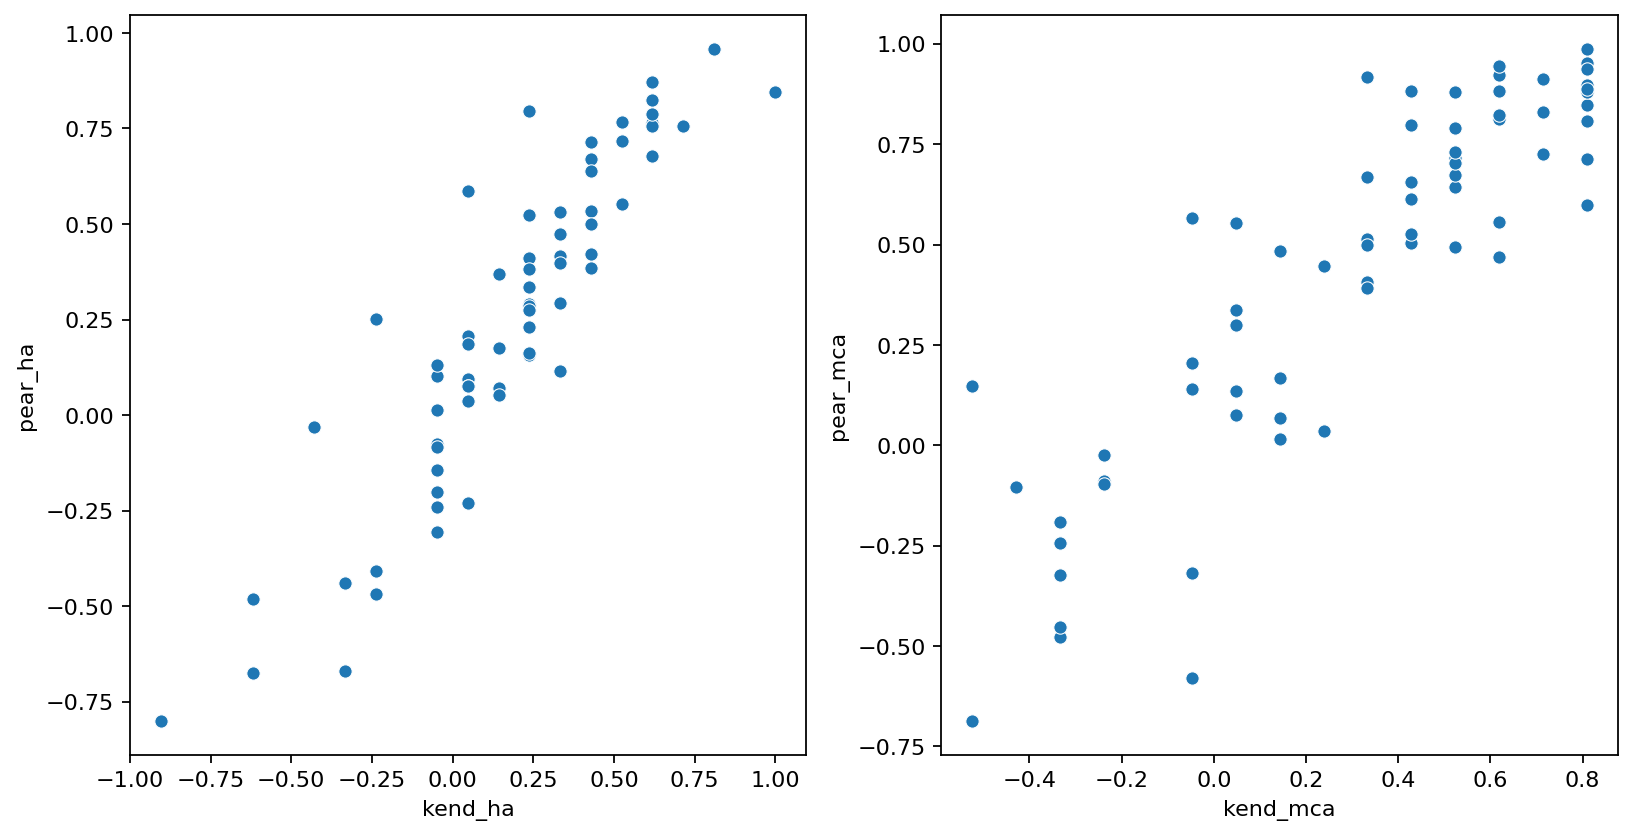

In [21]:
fig, ax = plt.subplots(1, 2, figsize=(12, 6), dpi=80)
sns.scatterplot(x=corr_df['kend_ha'], y=corr_df['pear_ha'], ax=ax[0])
ax[0].grid(False)

sns.scatterplot(corr_df, x=corr_df['kend_mca'], y=corr_df['pear_mca'], ax=ax[1])
ax[1].grid(False)

In [22]:
corr_df['label'] = 'Zero'
corr = "spear_diff"
corr_df.loc[corr_df[corr] > 0.3, 'label'] = 'human-specific'
corr_df.loc[(corr_df[corr] > 0) & (corr_df[corr] <= 0.3), 'label'] = 'maybe human-specific'
corr_df.loc[(corr_df[corr] < 0) & (corr_df[corr] >= -0.3), 'label'] = 'maybe age-specific'
corr_df.loc[corr_df[corr] < -0.3, 'label'] = 'age-specific'
corr_df.label.value_counts()

label
age-specific            28
maybe human-specific    14
maybe age-specific      13
human-specific          12
Name: count, dtype: int64

In [23]:
corr_df.label.to_csv('data/human_specific_genes/gene_groups.csv')

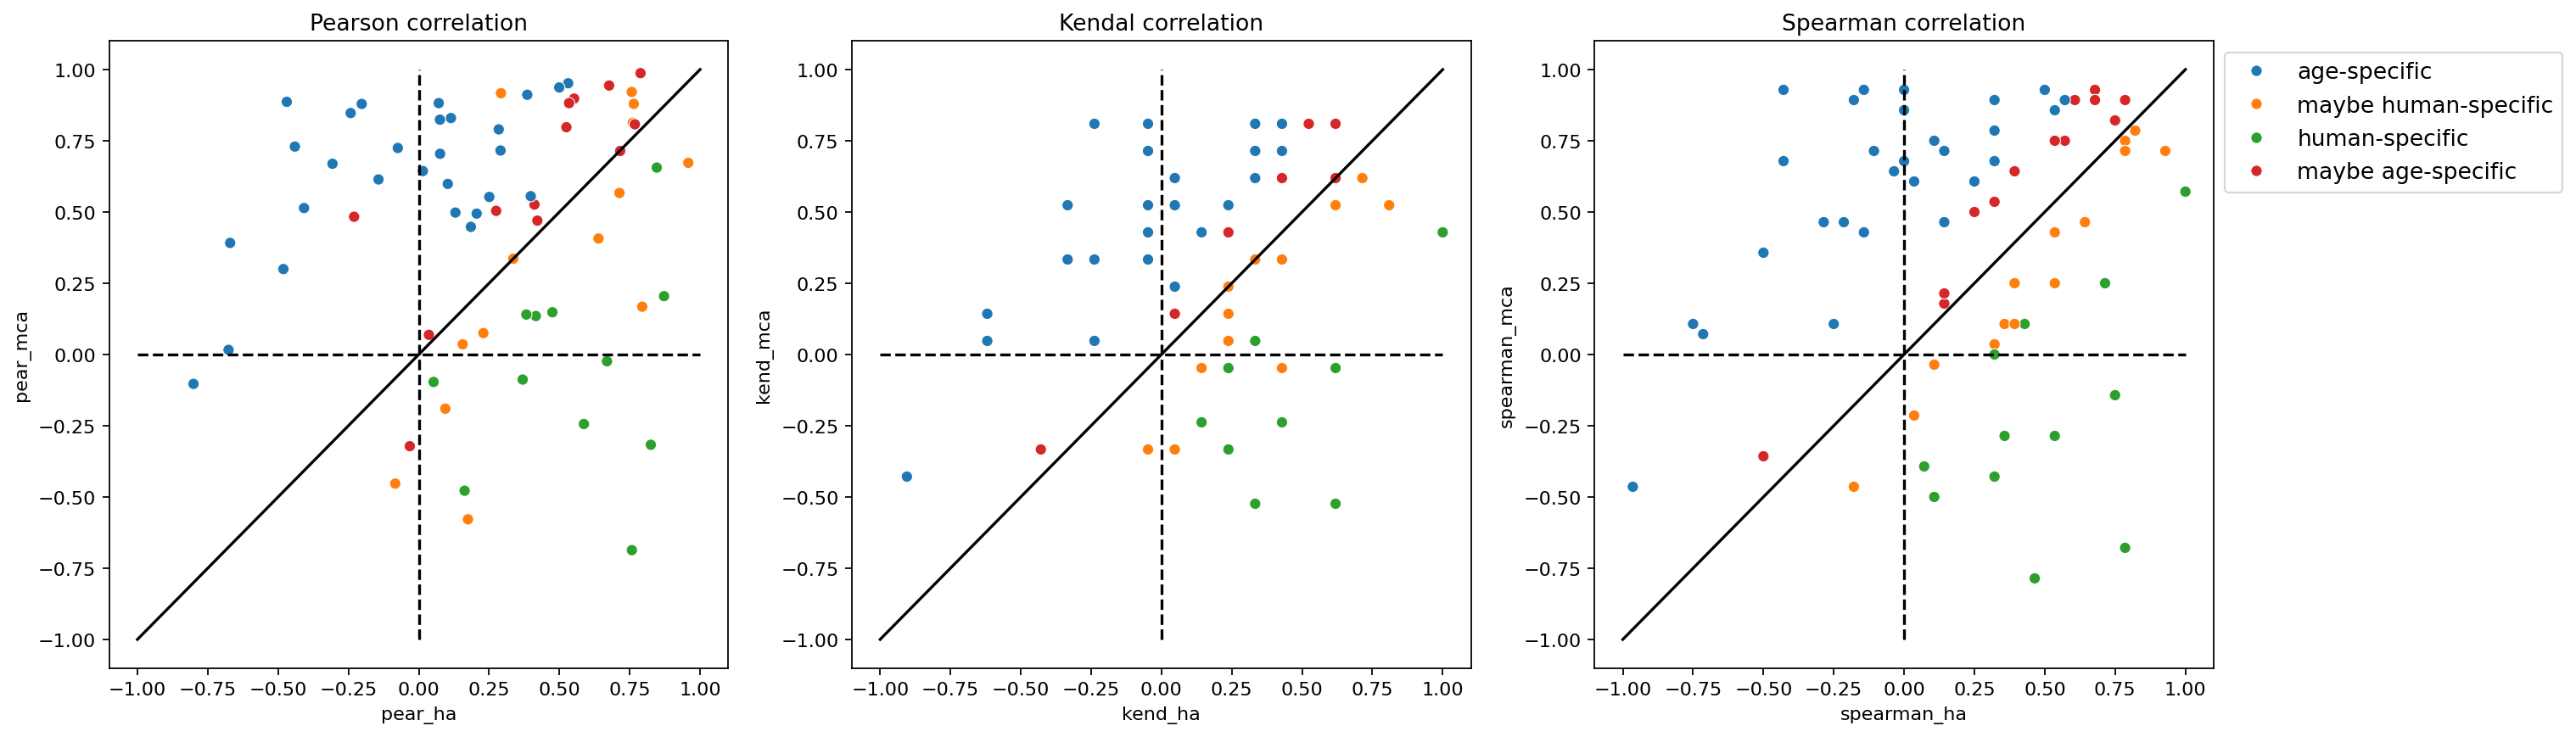

In [24]:
mpl.rcdefaults()

fig, ax = plt.subplots(1, 3, figsize=(20, 6), dpi=80)

sns.scatterplot(corr_df, x='pear_ha', y='pear_mca', ax=ax[0], hue='label')
ax[0].hlines(y=0, xmin=-1, xmax=1, colors='black', linestyles='dashed')
ax[0].vlines(x=0, ymin=-1, ymax=1, colors='black', linestyles='dashed')
ax[0].plot([-1, 1], [-1, 1], '-', color='black')
ax[0].set_title('Pearson correlation')
ax[0].grid(False)
ax[0].get_legend().remove()

sns.scatterplot(corr_df, x='kend_ha', y='kend_mca', ax=ax[1], hue='label')
ax[1].hlines(y=0, xmin=-1, xmax=1, colors='black', linestyles='dashed')
ax[1].vlines(x=0, ymin=-1, ymax=1, colors='black', linestyles='dashed')
ax[1].plot([-1, 1], [-1, 1], '-', color='black')
ax[1].set_title('Kendal correlation')
ax[1].grid(False)
ax[1].get_legend().remove()

sns.scatterplot(corr_df, x='spearman_ha', y='spearman_mca', ax=ax[2], hue='label')
ax[2].hlines(y=0, xmin=-1, xmax=1, colors='black', linestyles='dashed')
ax[2].vlines(x=0, ymin=-1, ymax=1, colors='black', linestyles='dashed')
ax[2].plot([-1, 1], [-1, 1], '-', color='black')
ax[2].set_title('Spearman correlation')
ax[2].grid(False)
ax[2].legend(fontsize=8, loc="upper left", bbox_to_anchor=(1, 1), prop={"size":12})

Text(0, 0.5, 'corr(adult vs newborn human) - corr(adult vs newborn macaque)')

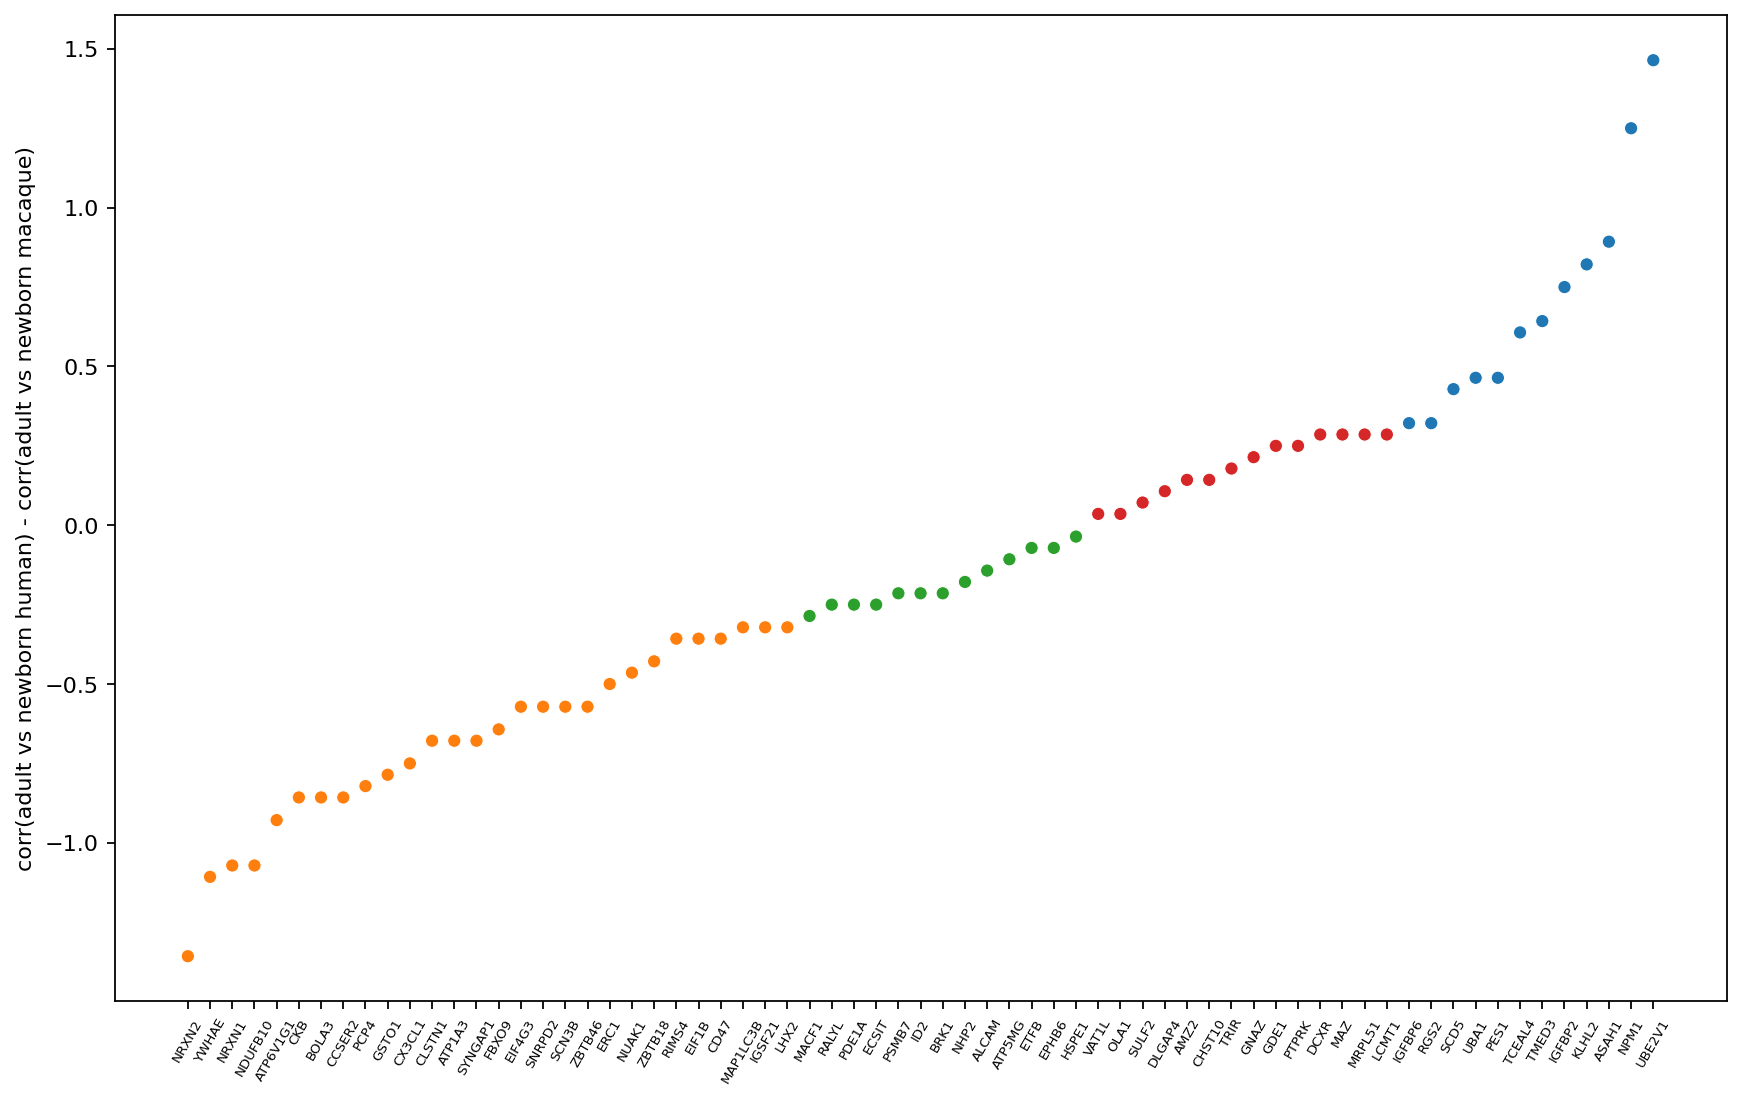

In [25]:
fig = plt.figure(figsize=(13, 8), dpi=80)
corr_df = corr_df.sort_values(by='spear_diff')
color_dict_labels = {'human-specific': 'tab:blue', 'age-specific': 'tab:orange', 'maybe human-specific': 'tab:red', 'maybe age-specific': 'tab:green'}
sns.scatterplot(corr_df['spear_diff'], color=corr_df.label.map(color_dict_labels))
plt.xticks(rotation=60, fontsize=6);
plt.ylabel("corr(adult vs newborn human) - corr(adult vs newborn macaque)", fontsize=10)

## Functional analysis

In [65]:
import utils.functional_analysis as utils

In [66]:
gene_clust = list()
enrich_results = list()

for group in ['age-specific', 'maybe age-specific', 'maybe human-specific', 'human-specific']:
    gene_set = corr_df[corr_df.label == group].index.to_list()
    gene_clust.append(utils.GeneCluster(gene_set, group, group, background_genes))
    time.sleep(1)

## GO_Biological_Process_2023

In [67]:
db_name = 'GO_Biological_Process_2025'
utils.GeneCluster.enrich_geneclusters(gene_clust,db_name )

In [68]:
enrich_res = pd.concat([gc.enrichment_res[db_name] for gc in gene_clust])
enrich_res = enrich_res.set_index(['Term'])
enrich_res.head()

,Rank,p-val,Z-score,Combined score,Overlapping genes,Adjusted P-value,Old p-value,Old adjusted p-value,num_overlap_genes,neg_log10(p_adj),cluster_label
Term,,,,,,,,,,,
Vocal Learning (GO:0042297),1,0.000037,597.846154,6097.736182,"[NRXN1, NRXN2]",0.004379,0,0,2,2.358629,age-specific
Imitative Learning (GO:0098596),2,0.000037,597.846154,6097.736182,"[NRXN1, NRXN2]",0.004379,0,0,2,2.358629,age-specific
Auditory Behavior (GO:0031223),3,0.000037,597.846154,6097.736182,"[NRXN1, NRXN2]",0.004379,0,0,2,2.358629,age-specific
Learned Vocalization Behavior or Vocal Learning (GO:0098598),4,0.000037,597.846154,6097.736182,"[NRXN1, NRXN2]",0.004379,0,0,2,2.358629,age-specific
Postsynaptic Density Assembly (GO:0097107),5,0.000123,199.230769,1793.071413,"[NRXN1, NRXN2]",0.008304,0,0,2,2.080715,age-specific


In [69]:
terms = enrich_res[(enrich_res['Adjusted P-value'] < 0.05) & (enrich_res.Rank < 10)].index.unique()
terms.size

12

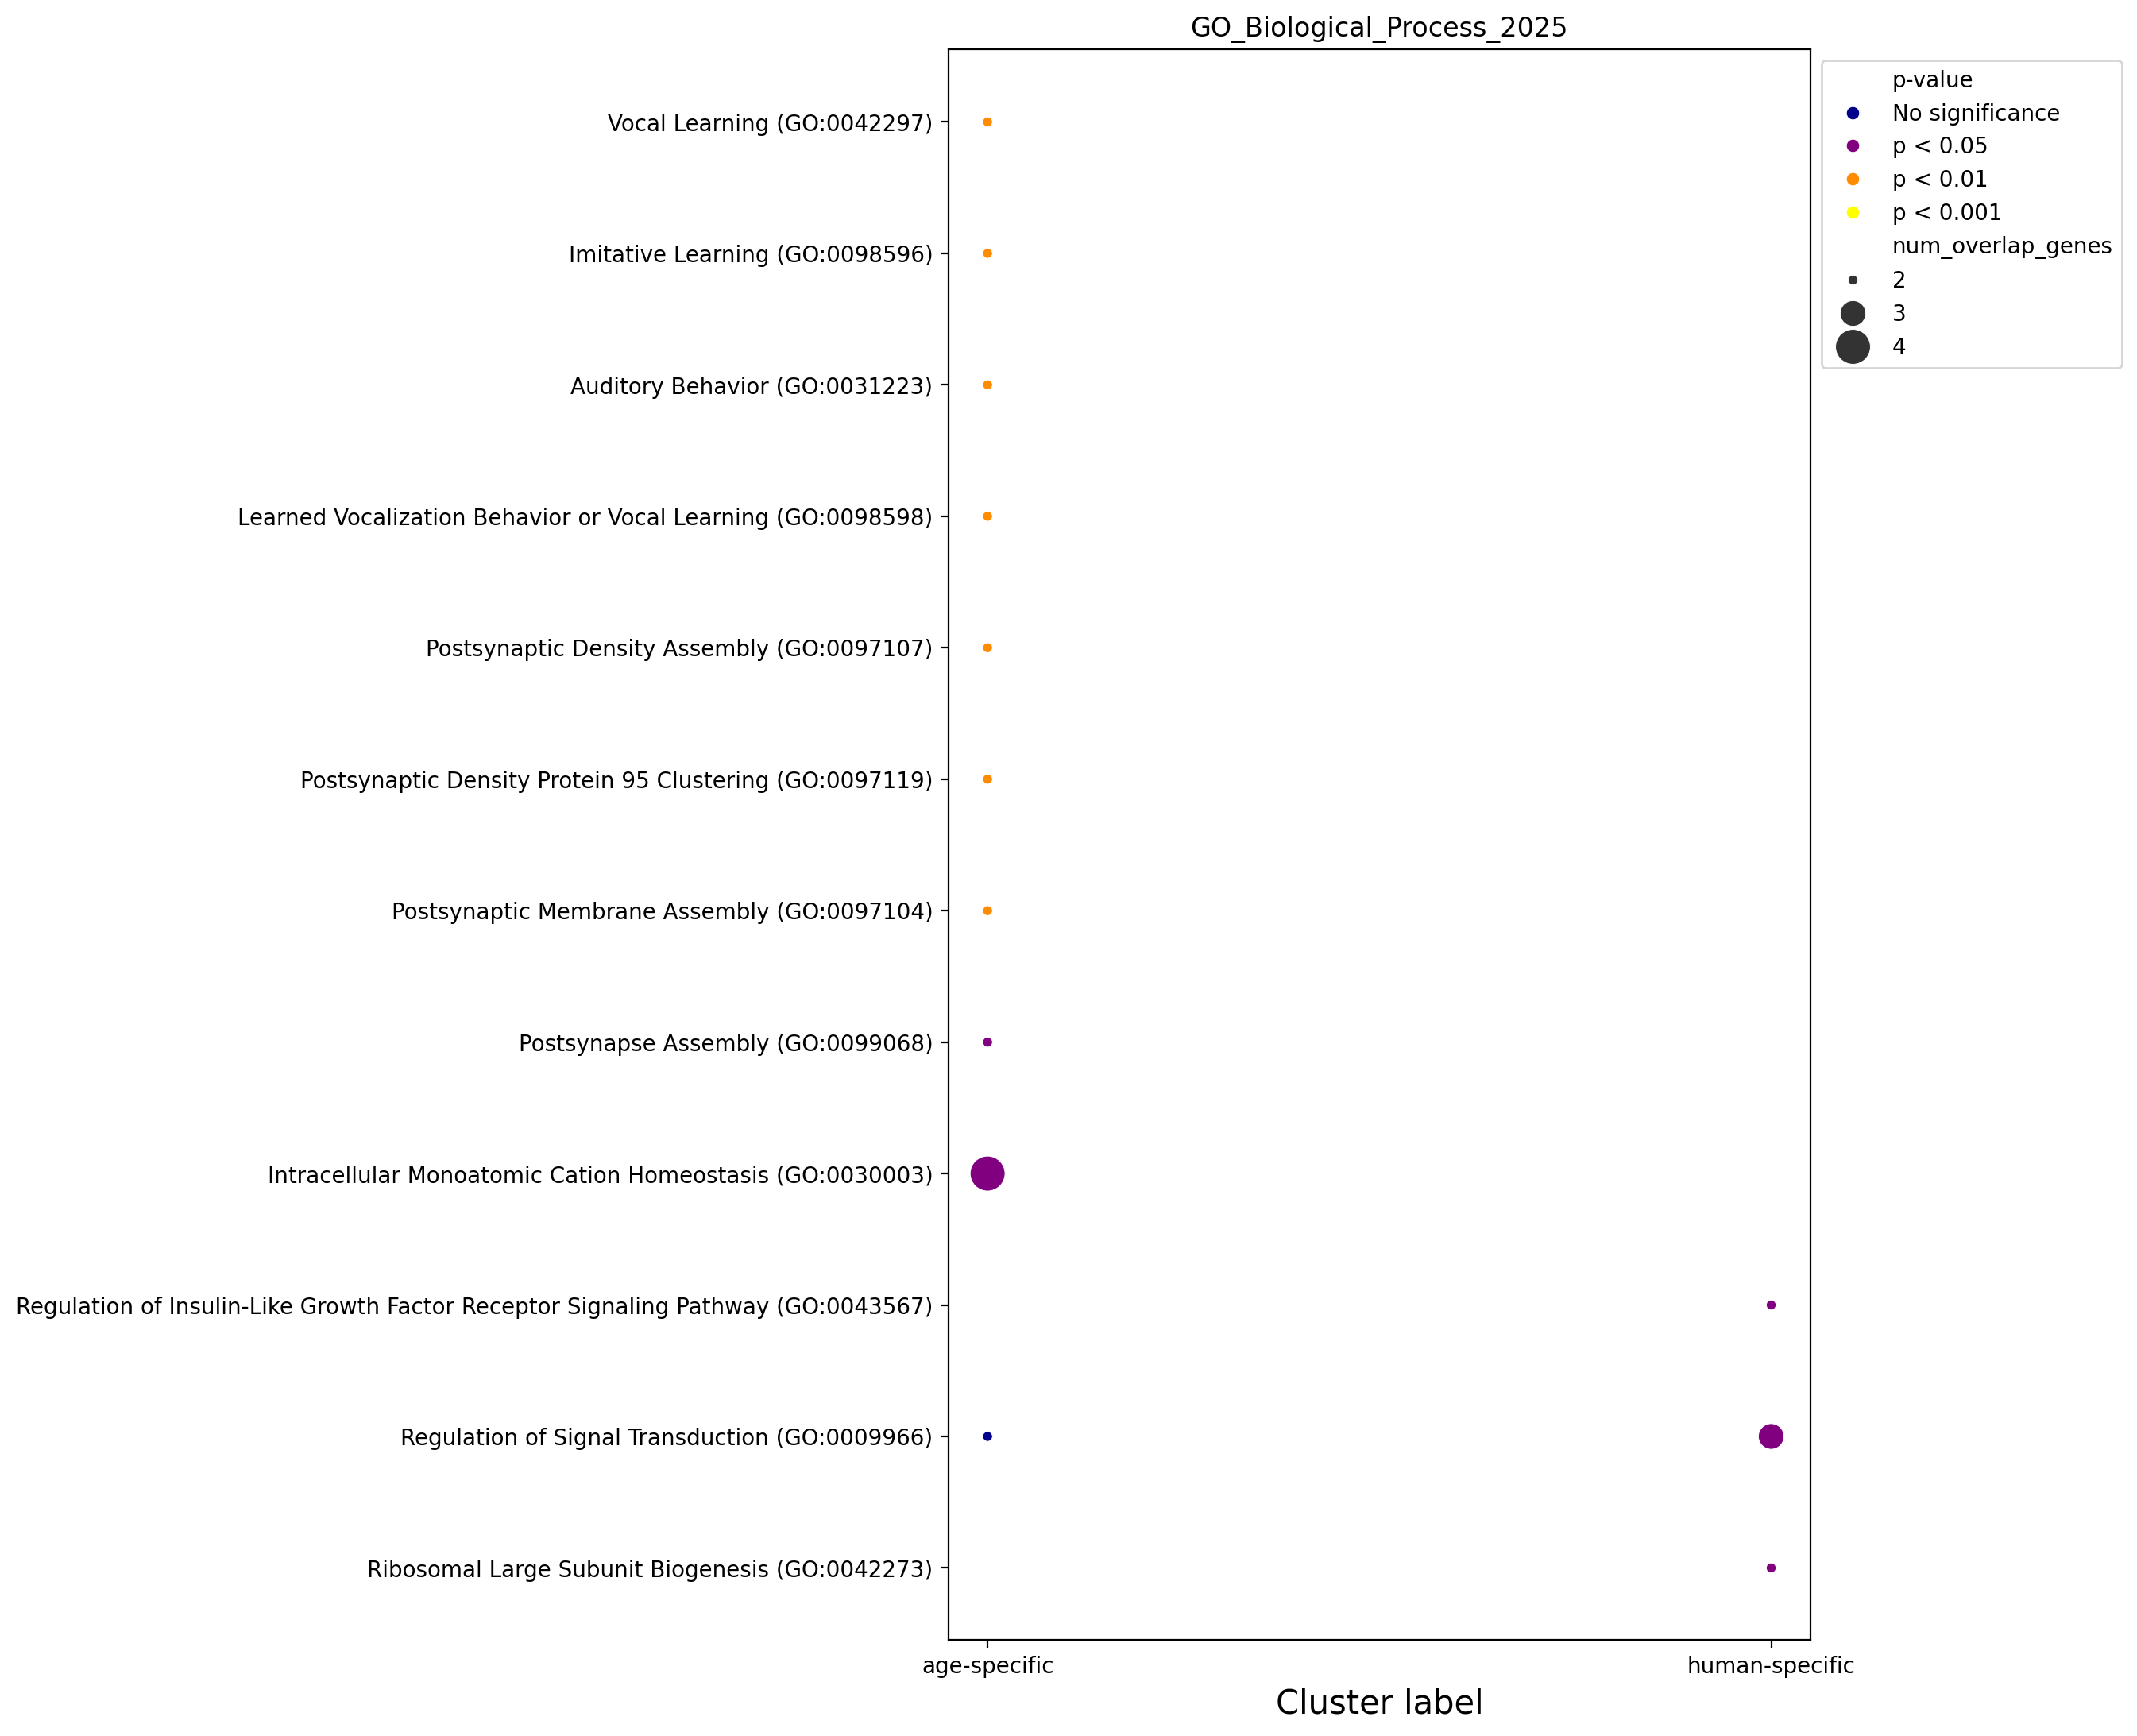

In [ ]:
fig, ax = utils.scatter_enrichment(
    enrich_res,
    terms,
    db_name,
    pval_groups=("No significance", "p < 0.05", "p < 0.01", "p < 0.001"),
    figsize=(7, 13),
    dpi=100,
    size_range=(20, 250),
    fontsize_row=5,
    fontsize_axis=15,
)

plt.savefig(f'{figures_dir}/go_biological_processes_2025_validation.jpg', bbox_inches='tight')
plt.savefig(f'{figures_dir}/go_biological_processes_2025_validation.pdf', bbox_inches='tight')
plt.show()

## Azimuth_Cell_Types_2021

In [71]:
db_name = 'Azimuth_Cell_Types_2021'
utils.GeneCluster.enrich_geneclusters(gene_clust,db_name )

In [72]:
enrich_res = pd.concat([gc.enrichment_res[db_name] for gc in gene_clust])
enrich_res = enrich_res.set_index(['Term'])
enrich_res.head()

,Rank,p-val,Z-score,Combined score,Overlapping genes,Adjusted P-value,Old p-value,Old adjusted p-value,num_overlap_genes,neg_log10(p_adj),cluster_label
Term,,,,,,,,,,,
RORB+ LNX2+ Layer 3-5 Glutamatergic Neuron CL0000679,1,0.014283,95.925926,407.561574,[PCP4],0.021350,0,0,1,1.670602,age-specific
VIP+ SLC7A6OS+ Layer 1-6 GABAergic Neuron CL0000617,2,0.017822,71.935185,289.704335,[PCP4],0.021350,0,0,1,1.670602,age-specific
Vip+ GABAergic Neuron 2 CL0000617,3,0.021350,57.540741,221.342161,[NRXN1],0.021350,0,0,1,1.670602,age-specific
FEZF2+ PKD2L1+ Layer 5 Glutamatergic Neuron CL0000679,1,0.000008,1415.818182,16673.276418,"[RALYL, PDE1A]",0.000108,0,0,2,3.968308,maybe age-specific
FEZF2+ LPO+ Layer 5-6 Glutamatergic Neuron CL0000679,2,0.003330,648.916667,3701.872163,[ALCAM],0.012505,0,0,1,1.902933,maybe age-specific


In [73]:
terms = enrich_res[(enrich_res['Adjusted P-value'] < 0.05) & (enrich_res.Rank < 10)].index.unique()
terms.size

19

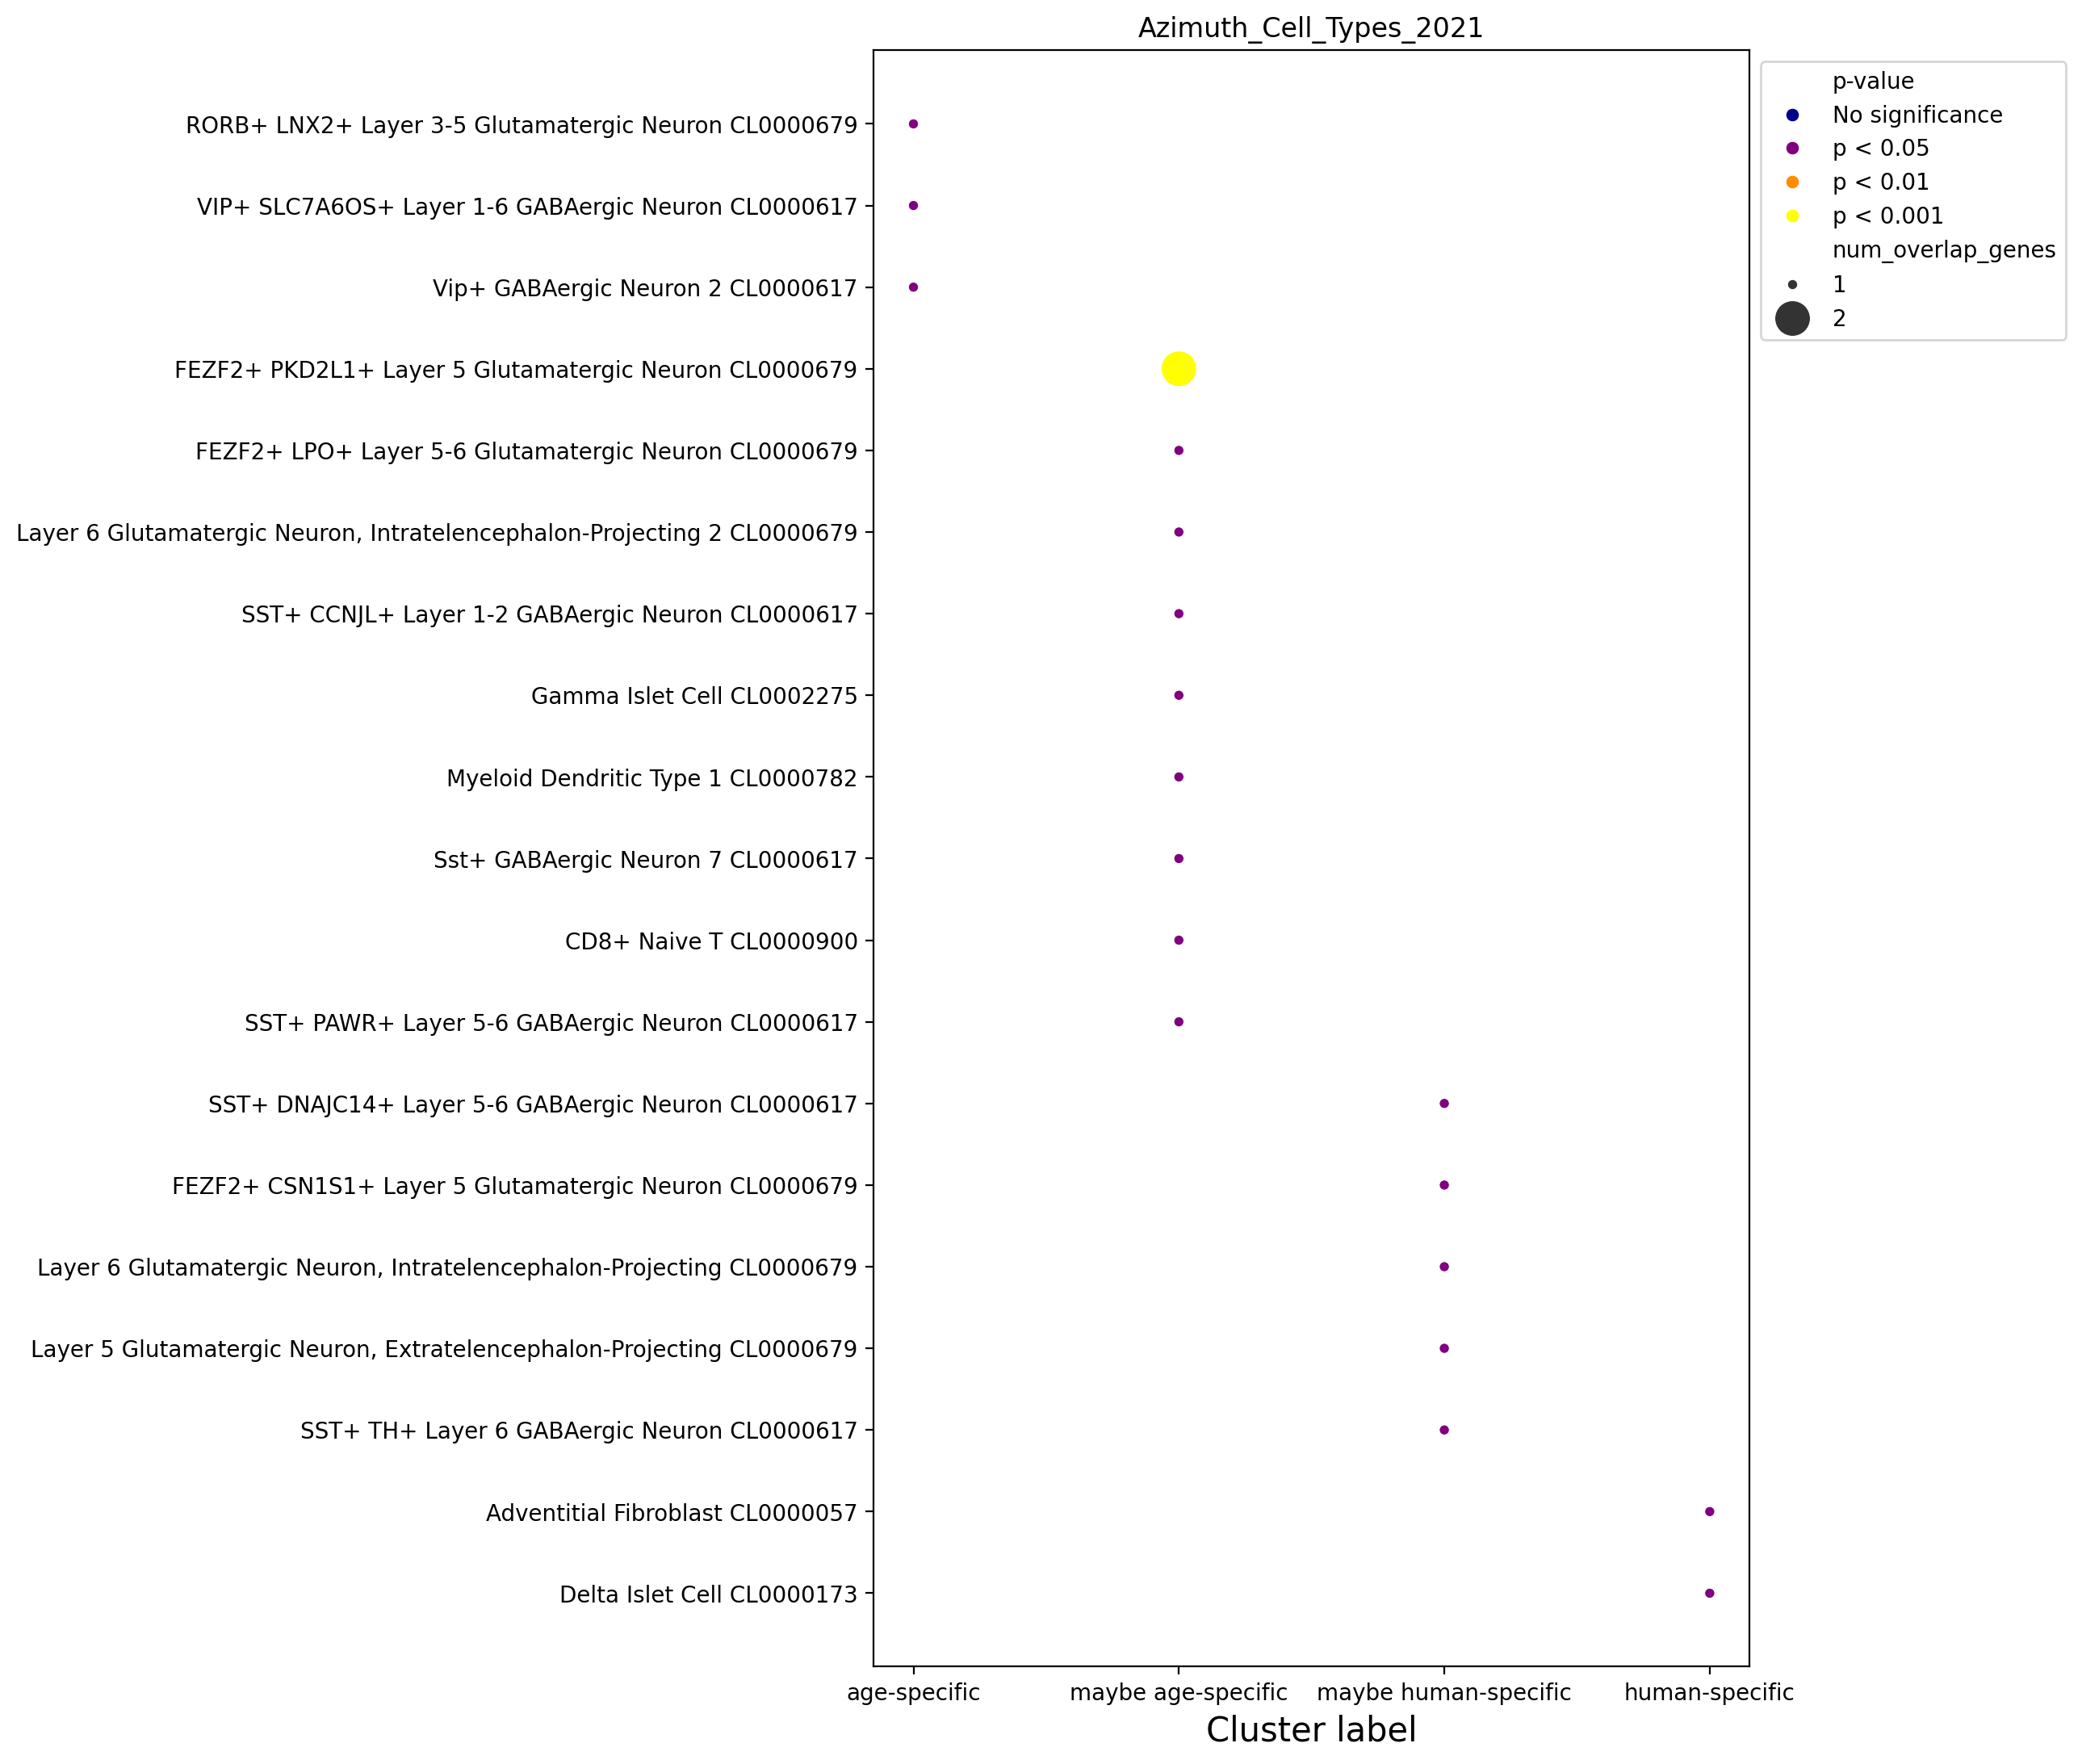

In [74]:
color_discrete_map = {
    "No significance": "darkblue",
    "p < 0.05": "purple",
    "p < 0.01": "darkorange",
    "p < 0.001": "yellow",
}


fig, ax = utils.scatter_enrichment(
    enrich_res,
    terms,
    color_discrete_map,
    db_name,
    pval_groups=("No significance", "p < 0.05", "p < 0.01", "p < 0.001"),
    figsize=(7, 13),
    dpi=100,
    size_range=(20, 250),
    fontsize_row=5,
    fontsize_axis=15,
)

## WikiPathways_2024_Human

In [75]:
db_name = 'WikiPathways_2024_Human'
utils.GeneCluster.enrich_geneclusters(gene_clust,db_name )

In [76]:
enrich_res = pd.concat([gc.enrichment_res[db_name] for gc in gene_clust])
enrich_res = enrich_res.set_index(['Term'])
enrich_res.head()

,Rank,p-val,Z-score,Combined score,Overlapping genes,Adjusted P-value,Old p-value,Old adjusted p-value,num_overlap_genes,neg_log10(p_adj),cluster_label
Term,,,,,,,,,,,
Disruption Of Postsynaptic Signaling By CNV WP4875,1,0.000128,37.190400,333.423133,"[SYNGAP1, NRXN1, NRXN2]",0.006899,0,0,3,2.161187,age-specific
Sudden Infant Death Syndrome SIDS Susceptibility Pathways WP706,2,0.002353,12.835000,77.680181,"[YWHAE, ATP1A3, SCN3B]",0.063521,0,0,3,1.197080,age-specific
Creatine Pathway WP5190,3,0.014283,95.925926,407.561574,[CKB],0.167841,0,0,1,0.775102,age-specific
Osteoclast Signaling WP12,4,0.021350,57.540741,221.342161,[ATP6V1G1],0.167841,0,0,1,0.775102,age-specific
Biomarkers For Pyrimidine Metabolism Disorders WP4584,5,0.021350,57.540741,221.342161,[CKB],0.167841,0,0,1,0.775102,age-specific


In [77]:
terms = enrich_res[(enrich_res['Adjusted P-value'] < 0.05) & (enrich_res.Rank < 10)].index.unique()
terms.size

10

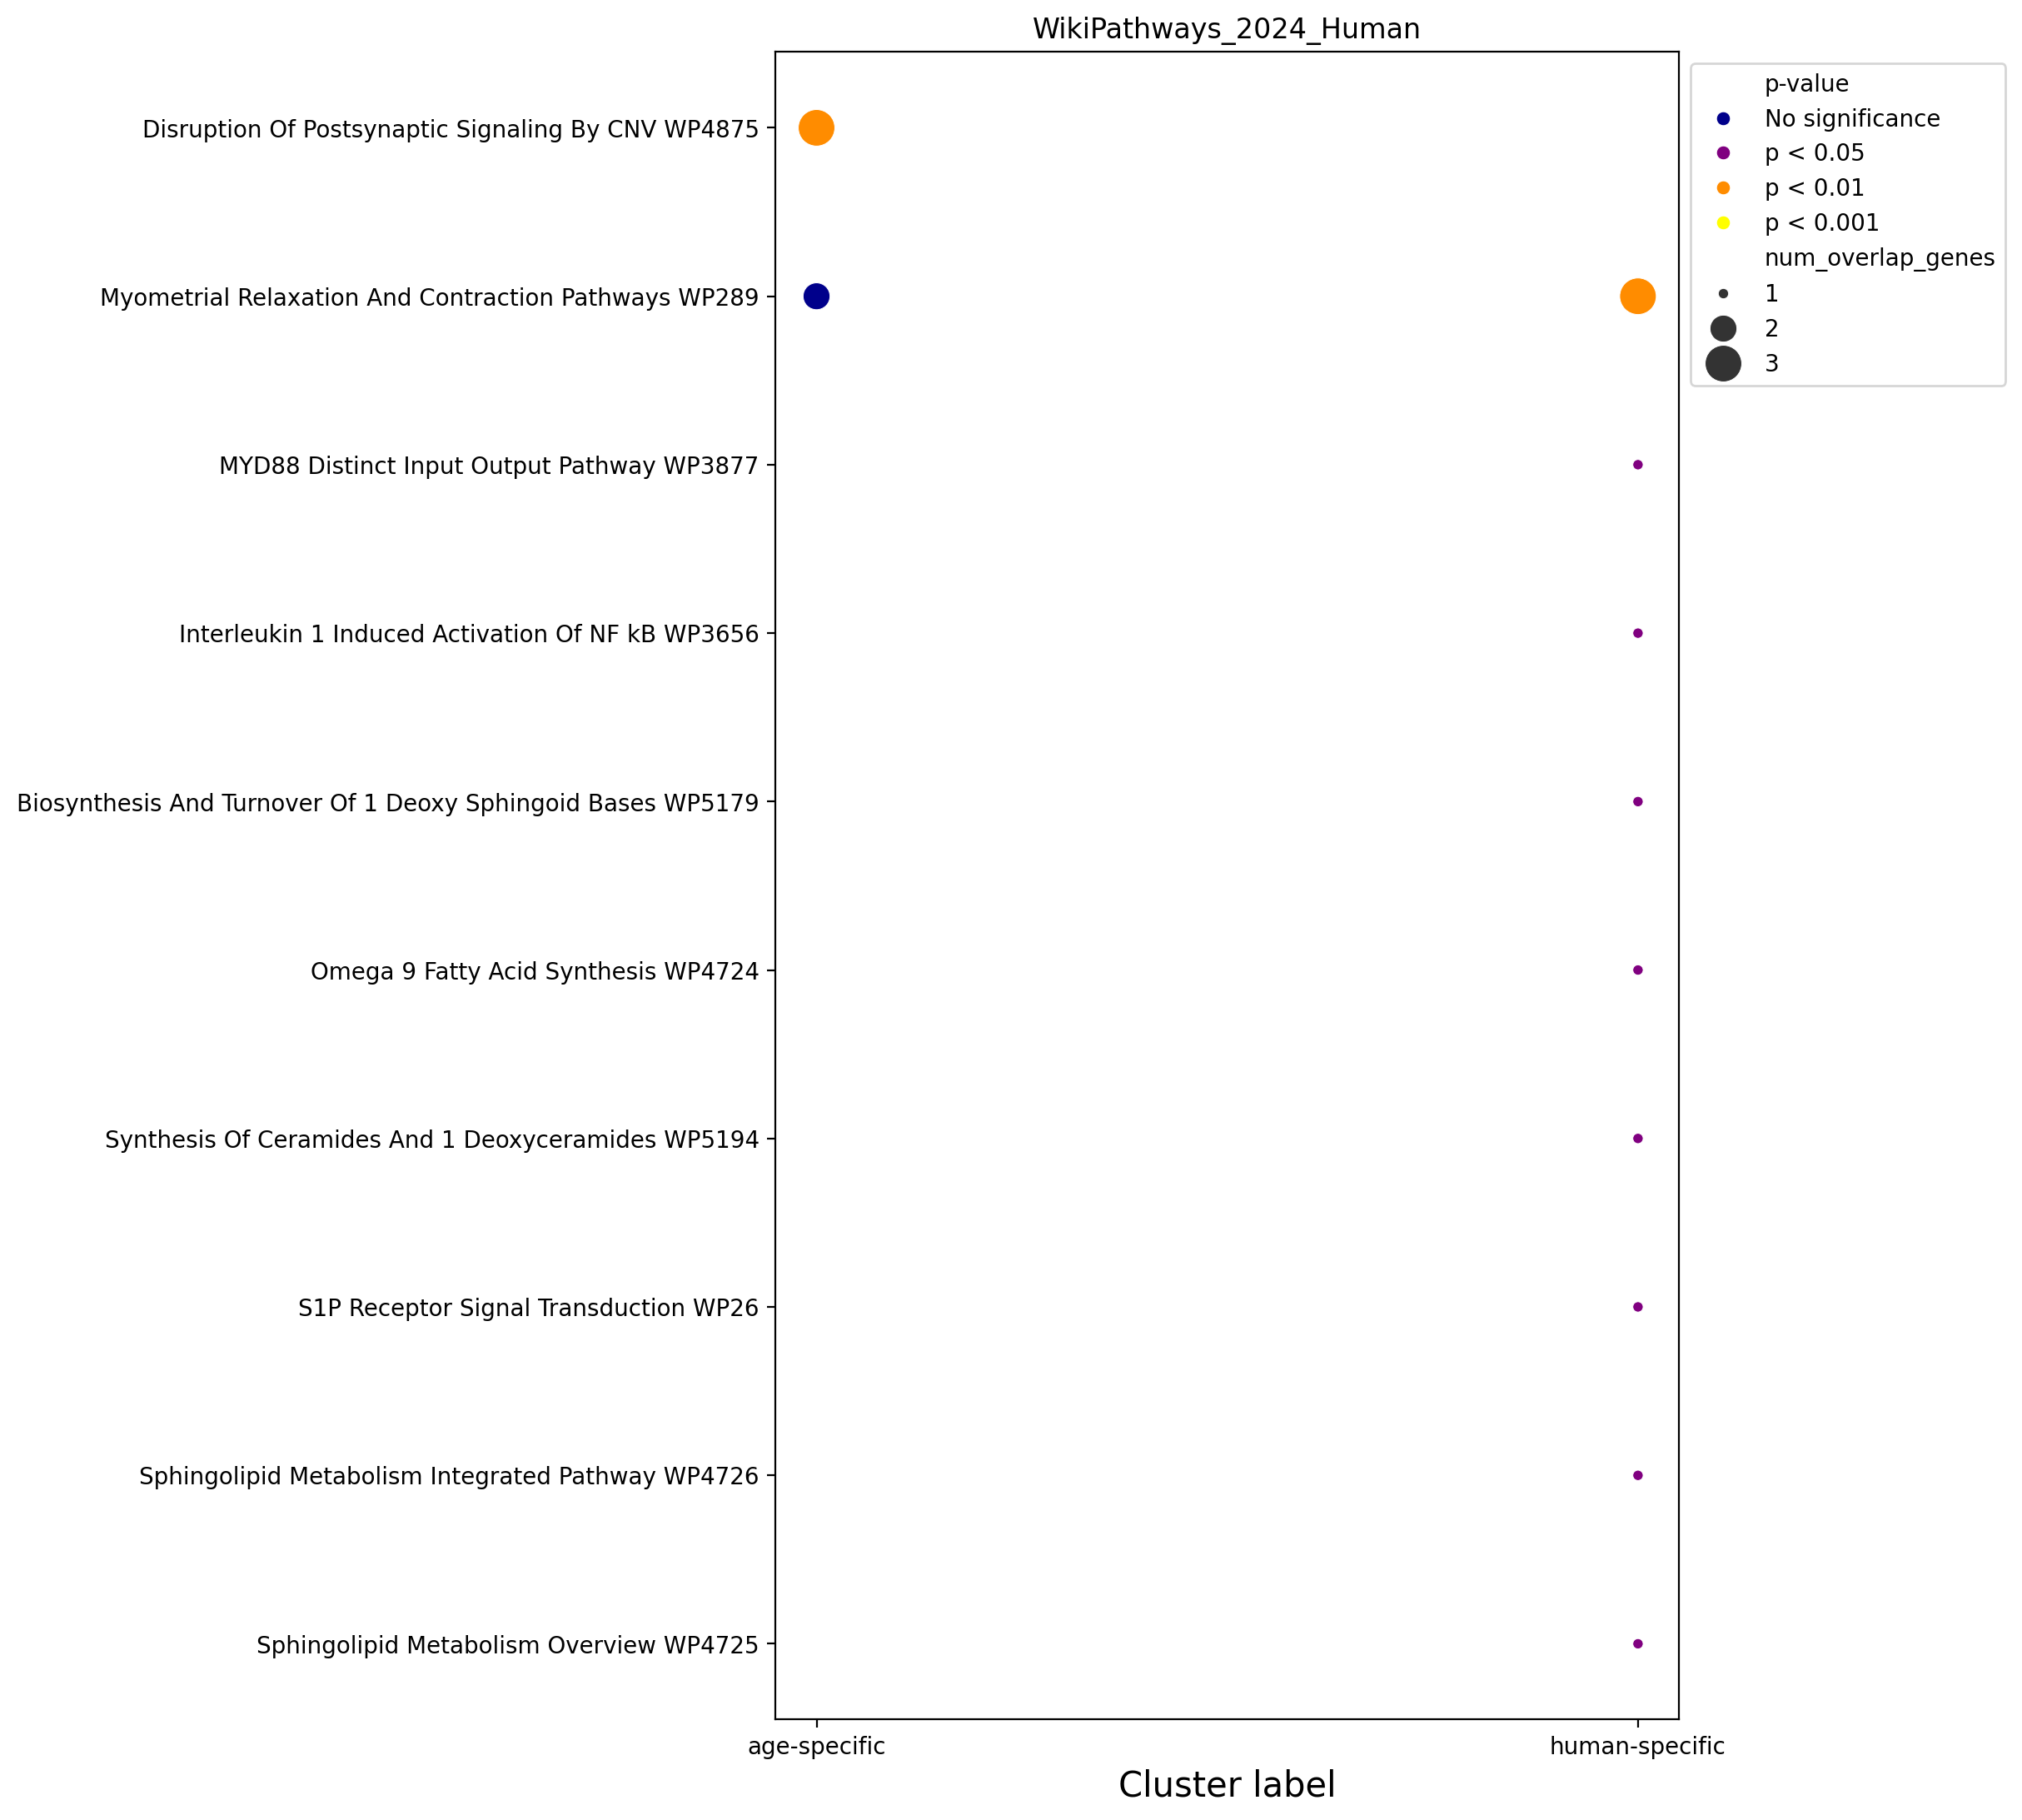

In [78]:
color_discrete_map = {
    "No significance": "darkblue",
    "p < 0.05": "purple",
    "p < 0.01": "darkorange",
    "p < 0.001": "yellow",
}


fig, ax = utils.scatter_enrichment(
    enrich_res,
    terms,
    color_discrete_map,
    db_name,
    pval_groups=("No significance", "p < 0.05", "p < 0.01", "p < 0.001"),
    figsize=(7, 13),
    dpi=100,
    size_range=(20, 250),
    fontsize_row=5,
    fontsize_axis=15,
)